In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima > /dev/null 2>&1
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

Load Dataset

In [2]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')

Preprocessing

In [3]:
# Konversi tanggal
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [4]:
# Filter Store 1 dan family GROCERY I
data = train[(train['store_nbr'] == 1) & (train['family'] == 'GROCERY I')].copy()

In [5]:
# Merge data tambahan
data = data.merge(stores, on='store_nbr', how='left')
data = data.merge(oil, on='date', how='left')

In [6]:
# Holidays: hanya tipe yang relevan
holidays_rel = holidays[holidays['type'].isin(['Holiday', 'Additional', 'Bridge', 'Transfer'])]
holidays_rel = holidays_rel[['date']].drop_duplicates()
holidays_rel['is_holiday'] = 1
data = data.merge(holidays_rel, on='date', how='left')
data['is_holiday'] = data['is_holiday'].fillna(0).astype(int)

In [7]:
# Feature engineering
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

In [8]:
# Handle missing oil price
data['dcoilwtico'] = data['dcoilwtico'].ffill().fillna(data['dcoilwtico'].mean())

In [9]:
# Set index tanggal & frekuensi harian
data = data.set_index('date')
data = data.asfreq('D').fillna({'sales': 0, 'onpromotion': 0, 'is_holiday': 0})  # fill missing dates

In [11]:
# Target
sales = data['sales']

print(f"Jumlah observasi setelah preprocessing: {len(sales)}")

Jumlah observasi setelah preprocessing: 255


In [98]:
# Tabel 1 untuk paper
table1_data = data[['sales', 'onpromotion', 'dcoilwtico', 'is_holiday', 'day_of_week']].copy()

# Tambah kolom month & year kalau mau ditampilkan juga
table1_data['month'] = data.index.month
table1_data['year']  = data.index.year

# Hitung statistik deskriptif
desc = table1_data.describe().round(2)

# Transpose biar rapi di paper
desc_T = desc.T

# Ganti nama kolom biar sesuai jurnal
desc_T.columns = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']
desc_T = desc_T[['Mean', 'Std', 'Min', 'Max']]  # cukup 4 kolom ini biar tidak terlalu penuh

# Tambah deskripsi manual
desc_T['Description'] = [
    'Daily sales volume (units)',
    'Number of items on promotion',
    'Daily crude oil price (USD)',
    'Holiday indicator (1 = holiday)',
    'Day of week (0 = Monday)',
    'Month (1–12)',
    'Year'
]

# Urutkan kolom sesuai keinginan
desc_T = desc_T[['Description', 'Mean', 'Std', 'Min', 'Max']]

# Tampilkan rapi
print("Table 1. Variables and Descriptive Statistics of the Processed Dataset")
print(desc_T.to_string(index=True))

Table 1. Variables and Descriptive Statistics of the Processed Dataset
                                 Description     Mean     Std      Min      Max
sales             Daily sales volume (units)  1771.63  522.01     0.00  3002.00
onpromotion     Number of items on promotion     0.00    0.00     0.00     0.00
dcoilwtico       Daily crude oil price (USD)    97.71    5.93    86.65   110.62
is_holiday   Holiday indicator (1 = holiday)     0.09    0.29     0.00     1.00
day_of_week         Day of week (0 = Monday)     2.99    2.00     0.00     6.00
month                           Month (1–12)     4.74    2.44     1.00     9.00
year                                    Year  2013.00    0.00  2013.00  2013.00


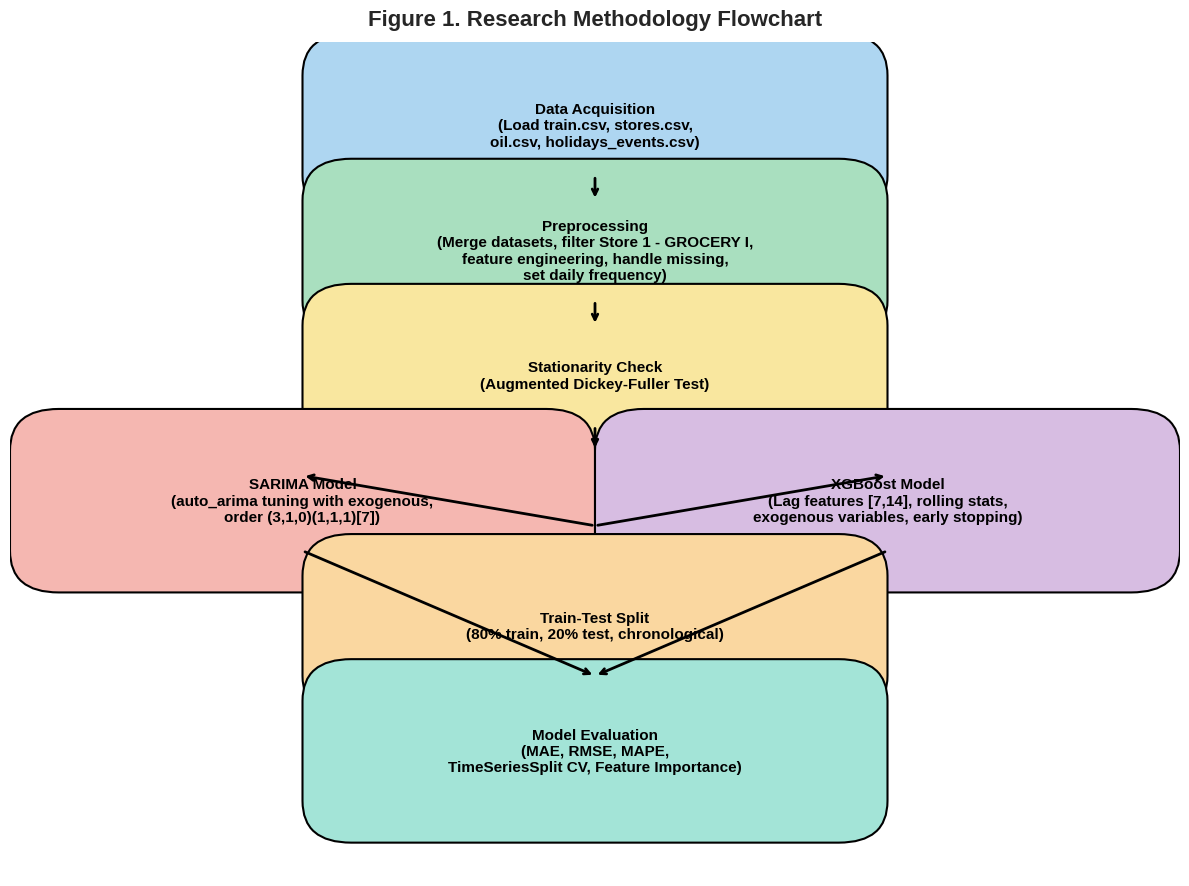

In [99]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

# Buat figure besar untuk kualitas jurnal
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim(0, 12)
ax.set_ylim(0, 10)
ax.axis('off')  # Hilangkan axis

# Kotak-kotak flowchart dengan warna berbeda
boxes = [
    (6, 9, 'Data Acquisition\n(Load train.csv, stores.csv,\noil.csv, holidays_events.csv)', '#AED6F1'),  # Biru muda
    (6, 7.5, 'Preprocessing\n(Merge datasets, filter Store 1 - GROCERY I,\nfeature engineering, handle missing,\nset daily frequency)', '#A9DFBF'),  # Hijau muda
    (6, 6, 'Stationarity Check\n(Augmented Dickey-Fuller Test)', '#F9E79F'),  # Kuning muda
    (3, 4.5, 'SARIMA Model\n(auto_arima tuning with exogenous,\norder (3,1,0)(1,1,1)[7])', '#F5B7B1'),  # Merah muda
    (9, 4.5, 'XGBoost Model\n(Lag features [7,14], rolling stats,\nexogenous variables, early stopping)', '#D7BDE2'),  # Ungu muda
    (6, 3, 'Train-Test Split\n(80% train, 20% test, chronological)', '#FAD7A0'),  # Oranye muda
    (6, 1.5, 'Model Evaluation\n(MAE, RMSE, MAPE,\nTimeSeriesSplit CV, Feature Importance)', '#A3E4D7')   # Toska
]

# Tambah kotak
for x, y, text, color in boxes:
    rect = patches.FancyBboxPatch((x-2.5, y-0.6), 5, 1.2,
                                  boxstyle="round,pad=0.5",
                                  facecolor=color,
                                  edgecolor='black',
                                  linewidth=1.5)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=11, weight='bold', color='black')

# Panah koneksi
arrows = [
    (6, 8.4, 6, 8.1),  # Dari Data Acq ke Preprocessing
    (6, 6.9, 6, 6.6),  # Ke Stationarity
    (6, 5.4, 6, 5.1),  # Ke Split
    (6, 4.2, 3, 4.8),  # Ke SARIMA
    (6, 4.2, 9, 4.8),  # Ke XGBoost
    (3, 3.9, 6, 2.4),  # SARIMA ke Evaluation
    (9, 3.9, 6, 2.4),  # XGBoost ke Evaluation
]

for x1, y1, x2, y2 in arrows:
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# Judul flowchart
plt.suptitle('Figure 1. Research Methodology Flowchart', fontsize=16, weight='bold', y=0.98)

# Simpan dengan kualitas tinggi
plt.tight_layout()
plt.savefig('Figure_1_Methodology_Flowchart.png', dpi=300, bbox_inches='tight')
plt.show()

In [103]:
adf_result = adfuller(sales.dropna())

# Output rapi
print("Augmented Dickey-Fuller Test Results")
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.12f}")
print(f"Number of Lags Used: {adf_result[2]}")
print(f"Number of Observations Used: {adf_result[3]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.3f}")

Augmented Dickey-Fuller Test Results
ADF Statistic: -2.948222
p-value: 0.040020976263
Number of Lags Used: 14
Number of Observations Used: 240
Critical Values:
   1%: -3.458
   5%: -2.874
   10%: -2.573


SARIMA

In [12]:
# Split 80-20 chronological
split = int(len(sales) * 0.8)
train_sales = sales[:split]
test_sales = sales[split:]

In [13]:
# Exogenous untuk SARIMA
exog_cols = ['onpromotion', 'dcoilwtico', 'is_holiday', 'day_of_week']
exog = data[exog_cols]
train_exog = exog[:split]
test_exog = exog[split:]

In [14]:
# Auto ARIMA dengan exogenous
print("Tuning SARIMA dengan auto_arima...")
sarima_model = auto_arima(
    train_sales,
    exogenous=train_exog,
    seasonal=True, m=7,
    start_p=0, start_q=0, max_p=3, max_q=3,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

Tuning SARIMA dengan auto_arima...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3025.779, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2908.992, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=2988.185, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=2889.355, Time=0.37 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=2858.007, Time=1.14 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=2856.093, Time=0.43 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=2862.155, Time=0.35 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=1.82 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=2855.781, Time=0.77 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=2890.599, Time=0.67 sec
 ARIMA(2,1,0)(0,1,2)[7]             : AIC=2850.933, Time=0.91 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=2854.721, Time=0.51 sec
 ARIMA(2,1,0)(1,1,2)[7]             : AIC=inf, Time=2.25 sec
 ARIMA(2,1,0)

In [15]:
# Fit & prediksi
sarima_fit = sarima_model.fit(train_sales, exogenous=train_exog)
sarima_pred = sarima_fit.predict(n_periods=len(test_sales), exogenous=test_exog)

In [59]:
common_test_index = y_test.index

sarima_pred_common = pd.Series(sarima_pred, index=test_sales.index).loc[common_test_index]

In [60]:
# Metrik SARIMA pada periode yang sama
sarima_mae_common = mean_absolute_error(y_test, sarima_pred_common)
sarima_rmse_common = np.sqrt(mean_squared_error(y_test, sarima_pred_common))
sarima_mape_common = mean_absolute_percentage_error(y_test, sarima_pred_common) * 100

In [17]:
print(f"\nSARIMA Best Model: {sarima_model.order}x{sarima_model.seasonal_order} [7]")
print(f"AIC: {sarima_model.aic():.2f}")
print(f"SARIMA - MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%")


SARIMA Best Model: (3, 1, 0)x(1, 1, 1, 7) [7]
AIC: 2847.18
SARIMA - MAE: 196.06, RMSE: 248.26, MAPE: 11.82%


In [94]:
# Diagnostic SARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# Residuals
residuals = sarima_fit.resid() # Call .resid() to get the residuals

# Ljung-Box test (p-value >0.05 = residual white noise, model baik)
lb_test = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print("Ljung-Box Test for Residual Autocorrelation:")
print(lb_test)

Ljung-Box Test for Residual Autocorrelation:
      lb_stat  lb_pvalue
10  14.158845   0.165869
20  18.831604   0.532795


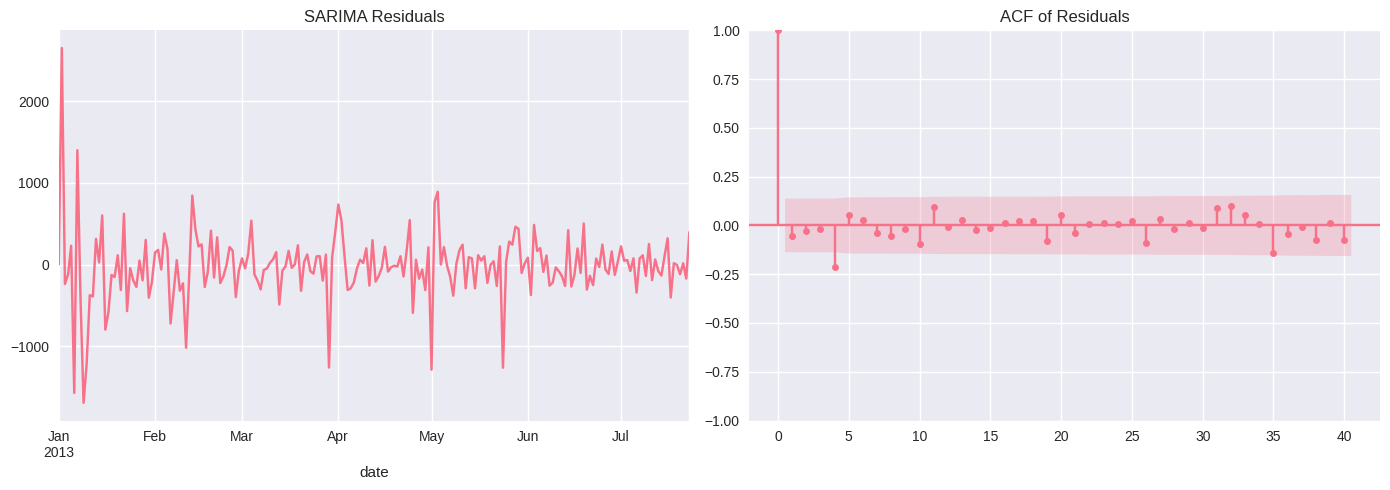

In [96]:
# Plot residuals & ACF residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
residuals.plot(title='SARIMA Residuals', ax=ax[0])
plot_acf(residuals, lags=40, title='ACF of Residuals', ax=ax[1])
plt.tight_layout()
plt.savefig('sarima_diagnostics.png', dpi=300)
plt.show()

XGBoost

In [81]:
# Feature engineering khusus XGBoost
def create_xgb_features(df):
    df = df.copy()
    # Pastikan index adalah date dan sorted
    df = df.sort_index()

    # Lag features (weekly dominant)
    for lag in [7, 14, 21, 28]:
        df[f'sales_lag_{lag}'] = df['sales'].shift(lag)

    # Rolling mean & std
    for window in [7, 14]:
        df[f'sales_roll_mean_{window}'] = df['sales'].shift(1).rolling(window=window).mean()
        df[f'sales_roll_std_{window}'] = df['sales'].shift(1).rolling(window=window).std()

    # Exogenous features
    df['oil_price'] = df['dcoilwtico']
    df['promotion'] = df['onpromotion']
    df['holiday'] = df['is_holiday']
    df['dow'] = df.index.dayofweek
    df['month'] = df.index.month

    return df

In [82]:
# Buat dataset XGBoost
df_xgb_full = data[['sales', 'onpromotion', 'dcoilwtico', 'is_holiday']].copy()
df_xgb_full = create_xgb_features(df_xgb_full)

In [83]:
# Hapus NaN (karena lag/rolling) — ini bikin dataset lebih pendek
df_xgb = df_xgb_full.dropna()

# Gunakan index yang sudah bersih untuk split
valid_dates = df_xgb.index
split_date = valid_dates[int(len(valid_dates) * 0.8)]

In [84]:
# Split berdasarkan date (chronological & akurat)
train_mask = df_xgb.index < split_date
test_mask = df_xgb.index >= split_date

X_train = df_xgb[train_mask].drop(columns=['sales'])
y_train = df_xgb[train_mask]['sales']
X_test = df_xgb[test_mask].drop(columns=['sales'])
y_test = df_xgb[test_mask]['sales']

In [85]:
print(f"Train period: {df_xgb[train_mask].index[0]} to {df_xgb[train_mask].index[-1]} ({len(y_train)} days)")
print(f"Test period: {df_xgb[test_mask].index[0]} to {df_xgb[test_mask].index[-1]} ({len(y_test)} days)")

Train period: 2013-01-29 00:00:00 to 2013-07-28 00:00:00 (181 days)
Test period: 2013-07-29 00:00:00 to 2013-09-12 00:00:00 (46 days)


In [86]:
# Train XGBoost
print("\nTraining XGBoost")
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


Training XGBoost


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [87]:
# Prediksi
xgb_pred = xgb_model.predict(X_test)

In [88]:
# Metrik XGBoost
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred) * 100

print(f"\nXGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2f}%")


XGBoost - MAE: 178.32, RMSE: 232.07, MAPE: 10.43%


BEST MODEL

In [89]:
print("PERBANDINGAN AKURASI AKHIR")
print(f"SARIMA  : MAE = {sarima_mae_common:.2f} | RMSE = {sarima_rmse_common:.2f} | MAPE = {sarima_mape_common:.2f}%")
print(f"XGBoost : MAE = {xgb_mae:.2f} | RMSE = {xgb_rmse:.2f} | MAPE = {xgb_mape:.2f}%")

PERBANDINGAN AKURASI AKHIR
SARIMA  : MAE = 196.77 | RMSE = 246.74 | MAPE = 11.73%
XGBoost : MAE = 178.32 | RMSE = 232.07 | MAPE = 10.43%


In [90]:
if xgb_rmse < sarima_rmse_common:
    print("\nBEST MODEL: XGBoost")
else:
    print("\nBEST MODEL: SARIMA")


BEST MODEL: XGBoost


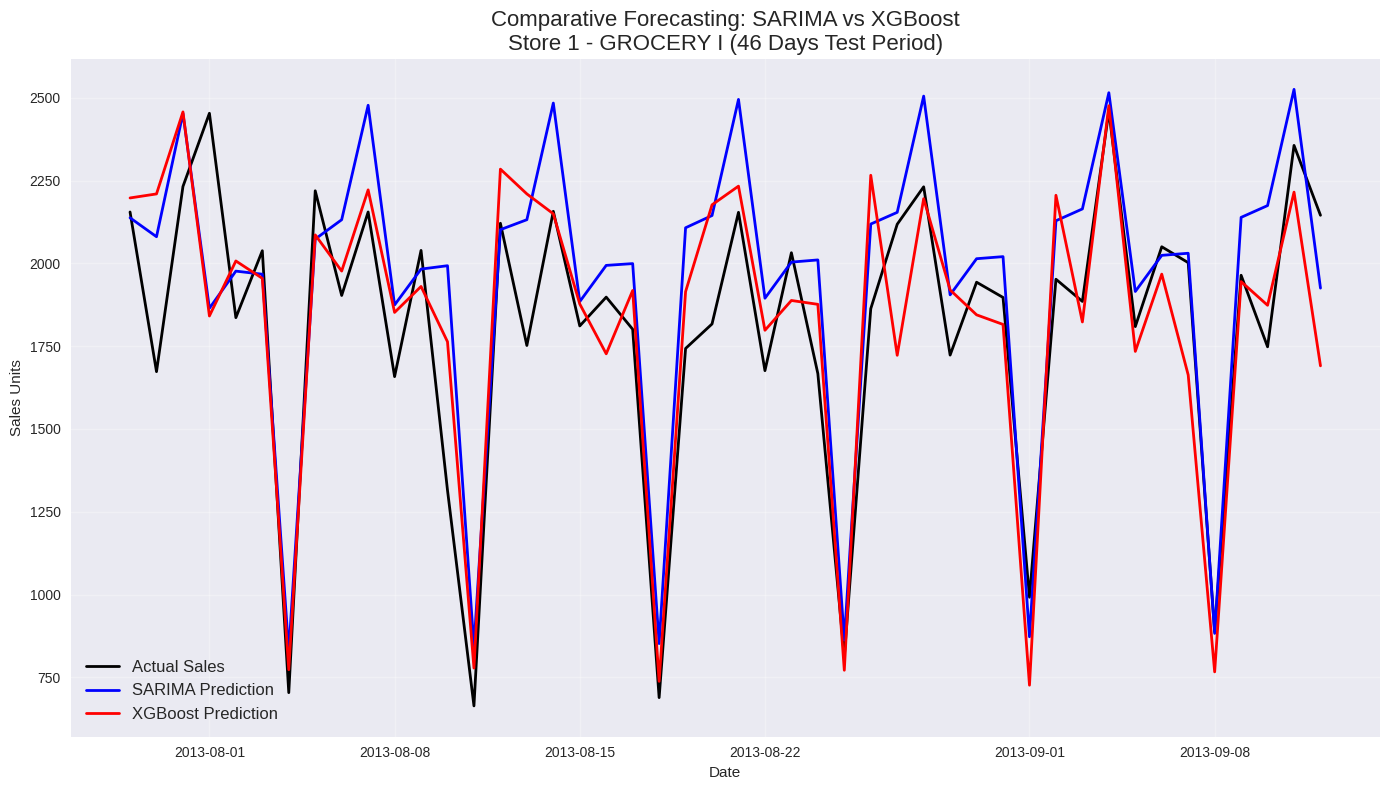

In [91]:
plt.figure(figsize=(14, 8))
plt.plot(common_test_index, y_test, label='Actual Sales', linewidth=2, color='black')
plt.plot(common_test_index, sarima_pred_common, label='SARIMA Prediction', linewidth=2, color='blue')
plt.plot(common_test_index, xgb_pred, label='XGBoost Prediction', linewidth=2, color='red')

plt.title(f'Comparative Forecasting: SARIMA vs XGBoost\nStore 1 - GROCERY I ({len(common_test_index)} Days Test Period)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('final_comparison_sarima_vs_xgboost.png', dpi=300)
plt.show()

In [68]:
print("\nTop 10 Feature Importance (XGBoost)")
importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(importance.head(10))


Top 10 Feature Importance (XGBoost)
dow                   0.541433
holiday               0.221766
is_holiday            0.059502
month                 0.030142
sales_lag_7           0.029824
sales_lag_28          0.029015
sales_lag_14          0.026100
sales_lag_21          0.021617
sales_roll_mean_14    0.010283
sales_roll_std_14     0.006811
dtype: float32


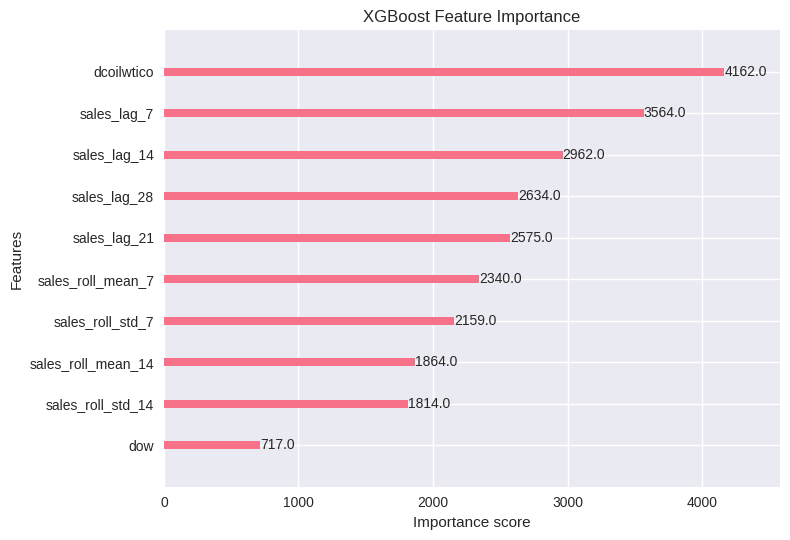

In [69]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=300)
plt.show()